In [10]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = int(np.sqrt(input_dim))

class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', 
                                 activation_fn=None)
        
        #Training the model to approximate Random Normal Distribution
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean= 0.0, stddev = 1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
def trainer(model_object, learning_rate=1e-4, 
            batch_size=64, num_epoch=100, n_z=16, log_step=5):
    model = model_object(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
            # Get a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and backward pass 
            # Report computed losses
            losses = model.run_single_step(batch[0])
        end_time = time.time()
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [4]:
model = trainer(VariantionalAutoencoder)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
[Epoch 0] recon_loss: 189.575  latent_loss: 4.414  total_loss: 193.989  (7.324 sec/epoch)
[Epoch 5] recon_loss: 128.221  latent_loss: 15.762  total_loss: 143.983  (6.557 sec/epoch)
[Epoch 10] recon_loss: 107.268  latent_loss: 17.701  total_loss: 124.969  (6.772 sec/epoch)
[Epoch 15] recon_loss: 102.129  latent_loss: 19.007  total_loss: 121.136  (6.655 sec/epoch)
[Epoch 20] recon_loss: 91.880  latent_loss: 20.703  total_loss: 112.583  (6.779 sec/epoch)
[Epoch 25] recon_loss: 102.066  latent_loss: 21.031  total_loss: 123.098  (7.352 sec/epoch)
[Epoch 30] recon_loss: 88.930  latent_loss: 20.800  total_loss: 109.730  (6.588 sec/epoch)
[Epoch 35] recon_loss: 86.928  latent_loss: 20.347  total_loss: 107.276  (6.555 sec/epoch)
[Epoch 40] recon_loss: 85.206  latent_loss: 20.703  total_loss: 105.909  (6.592 sec/epoch)
[Epoch 45] recon_loss: 83.906  latent_loss: 21.511  total_l

In [0]:
def test_reconstruction(model, mnist, h=28, w=28, batch_size=100):
    # Test the trained model: reconstruction
    batch = mnist.test.next_batch(batch_size)
    x_reconstructed = model.reconstructor(batch[0])

    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 batch[0][i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    plt.figure(figsize=(10, 20))
    plt.imshow(I_reconstructed, cmap='gray')

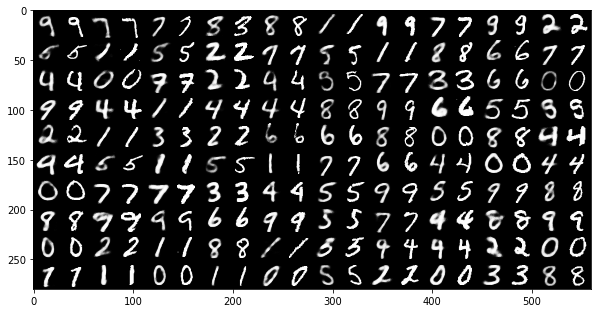

In [6]:
test_reconstruction(model, mnist)

***************************
Values Drawn from sample :
***************************

*****************************************
The Sample Vector Dimensions : 16
Total Samples we are Passing :  64
*****************************************

[ 1.78216358  0.58357614  0.27680746  0.52720926 -0.26110955 -0.57502666
 -1.01208909 -0.06381047  0.46532551 -0.00285279 -1.33525426 -0.44688957
  0.44527705  0.89272842  0.2743696  -0.77054038]
[-0.32194819  0.04660468 -0.8547364  -2.2718307  -0.35881341 -0.61513396
 -1.29428351 -0.2242015   0.6680609   0.81567221  0.46829597  0.18780037
  0.05726872  0.613735    0.31805546  0.3532014 ]
[ 0.88293645 -0.99793049  1.0830268  -1.31950032  0.85272503  0.36430683
 -1.05987528 -0.03713929 -0.0045821  -2.73339918  0.37800772 -0.69442129
 -1.61556181  1.65252129 -1.73508966 -1.49102321]
[-0.27764598  1.09930446  0.11657498 -0.08988886 -1.0110609  -0.01440147
 -1.39282265  0.93137846 -0.61363888 -0.2509392   1.5621253   0.05869301
  1.14362002  0.0968758   1.

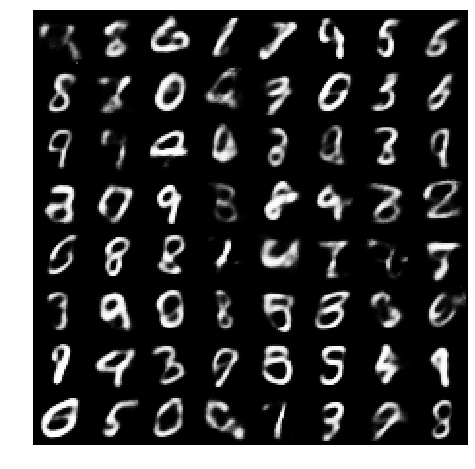

In [9]:
# Test the trained model: generation
# Sample noise vectors from Random Normal Distribution : uni(-3,3)

z = np.random.normal(size = [model.batch_size, model.n_z])


print("***************************")
print("Values Drawn from sample :")
print("***************************")

print()

print("*****************************************")

print("The Sample Vector Dimensions :",model.n_z)
print("Total Samples we are Passing : ",model.batch_size)
print("*****************************************")
print()

for i in z:
  print(i)

print()
print("***************************")
print("Output Images :")
print("***************************")


x_generated = model.generator(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(h, w)

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(I_generated, cmap='gray')